In [1]:
!pip install -q datasets
!pip install -q py-readability-metrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import random

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from collections import Counter

from readability import Readability

# wordcloud
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Notes:**
- FRE 0 to 100 with 100 being most readable
- Dale-Chall 5-10 (typically) with 10 being more difficult

**Results:**

Texts

| | FRE | Dale-Chall| Length |
| -- | -- | -- | -- |
| **SAT** | **47.432** | **9.875** | **144.341** |
| RACE-H | 64.499 | 7.960 | 355.574 |
| MultiRC | **55.474** | **9.167** | 459.074 |
| MCTest | 85.074 | 6.207 | **247.100** |

Questions

| | FRE | Dale-Chall| Length |
| -- | -- | -- | -- |
| **SAT** | **65.390** | **10.484** | **17.475** |
| RACE-H | 75.854 | 8.190 | 11.412 |
| MultiRC | **70.854** | **9.214** | **12.486** |
| MCTest | 86.554 | 8.096 | 10.959 |

Answers/Options

| | FRE | Dale-Chall| Length |
| -- | -- | -- | -- |
| **SAT** | **41.038** | **10.482** | |
| RACE-H | **64.391** | 9.044 | |
| MultiRC | 67.635 | **9.124** | |
| MCTest | 92.384 | 6.778 | |

Overall thoughts:
- RACE-H is the only dataset to contain similarly formatted questions (i.e. fill in the blank)
- MultiRC is the most similar in terms of readability, but focuses on a wider range of texts (e.g. news articles, historical documents, etc.) and is in a different format to the SAT
- all comparison datasets seem to have a more diverse vocabularly and are overall less formulaic than SAT

Recommendation: RACE-H for having the closest test format and structure.


# SAT Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_url = 'https://docs.google.com/spreadsheets/d/1A-8AQN3dGyuTkNrLx3dYvs5F5nRrxsKn06IaUcs7KQ0/export?format=csv&'
sheet_ids = ['gid=561768416', # Fall 2024
             'gid=810773814', # Test 4
             'gid=661652185', # Test 5
             'gid=0', # Test 6
             'gid=132269204', # Test 7
             'gid=954091148', # Test 8
             'gid=1498935535', # Test 9
             'gid=1969401332'] # Test 10
dfs = []
for id in sheet_ids:
  sheet_df = pd.read_csv(data_url + id)
  print(len(sheet_df))
  dfs.append(pd.read_csv(data_url + id))

sat_df = pd.concat(dfs)
print('\nTotal Number of SAT/ACT Questions: ', len(sat_df))
sat_df.head()

889
60
60
61
61
61
61
61

Total Number of SAT/ACT Questions:  1314


prompt  \
0  Marta Coll and colleagues’ 2010 Mediterranean ...   
1  A common assumption among art historians is th...   
2   Believing that living in an impractical space...   
3  In her 2021 article “Throwaway History: Toward...   
4  The most recent iteration of the immersive the...   

                                            question  \
0    Which choice most logically completes the text?   
1  Based on the text, what can be concluded about...   
2  Which choice best states the main idea of the ...   
3    Which choice most logically completes the text?   
4  What does the text most strongly suggest about...   

                                                mc_a  \
0  Coll and colleagues reported a much higher num...   
1  Factors other than the rise of photography may...   
2  Although inhabiting a home surrounded by fanci...   
3  demonstrate the difficulties faced by contempo...   
4  The choice of a New York City venue likely ena...   

                                                mc_b  \
0  some differences observed in microorganisms ma...   
1  Although portrait miniatures became less commo...   
2  Designing disorienting spaces like those in th...   
3  represent the challenge of incorporating examp...   
4  Audience members likely find the experience of...   

                                                mc_c  \
0  Bianchi and Morri may have been less sensitive...   
1  The popularity of the portrait miniature likel...   
2  As a filmmaker, Yamaoka has long supported the...   
3   lend support to arguments by historians and o...   
4  The production’s dependence on a particular pe...   

                                                mc_d answer  
0  the absence of clarity regarding how to differ...      b  
1  As demand for portrait miniatures decreased, p...      a  
2  Although impractical, the design of the apartm...      d  
3  illustrate both the relatively low scholarly r...      d  
4  Audience members who navigate the space accord...      c

In [ ]:
sat_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1314 entries, 0 to 60
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   prompt    1314 non-null   object
 1   question  1313 non-null   object
 2   mc_a      1314 non-null   object
 3   mc_b      1314 non-null   object
 4   mc_c      1314 non-null   object
 5   mc_d      1313 non-null   object
 6   answer    1314 non-null   object
dtypes: object(7)
memory usage: 82.1+ KB


In [ ]:
sat_df[sat_df.question.isna()]

prompt question        mc_a  \
3  To demonstrate that the integrity of undergrou...      NaN  hypnotized   

         mc_b       mc_c       mc_d answer  
3  discounted  redefined  exploited      D

In [ ]:
# average length
print(f'Average prompt length: {sat_df.dropna().prompt.apply(lambda x: len(word_tokenize(x))).mean()}')
print(f'Average question length: {sat_df.dropna().question.apply(lambda x: len(word_tokenize(x))).mean()}')

Average prompt length: 122.46189024390245
Average question length: 19.201981707317074


In [ ]:
# example
ex = sat_df.dropna().sample()
for col in ex.columns:
  print(f'\n{col}: {ex[col].iloc[0]}')


prompt: At two weeks old, the time their critical socialization period begins, wolves can smell but cannot yet see or hear. Domesticated dogs, ______ can see, hear, and smell by the end of two weeks. This relative lack of sensory input may help explain why wolves behave so differently around humans than dogs do: from a very young age, wolves are more wary and less exploratory.

question: Which choice completes the text with the most logical transition?

mc_a: in other words,

mc_b: for instance,

mc_c: by contrast,

mc_d: accordingly,

answer: C


In [ ]:
# most common words

wc_prompt = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(sat_df.prompt.str.cat(sep=' '))

wc_question = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(sat_df.question.str.cat(sep=' '))

wc_options = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(sat_df[['mc_a', 'mc_b', 'mc_c', 'mc_d']].apply(tuple, axis=1).str.join(' ').str.cat(sep=' '))

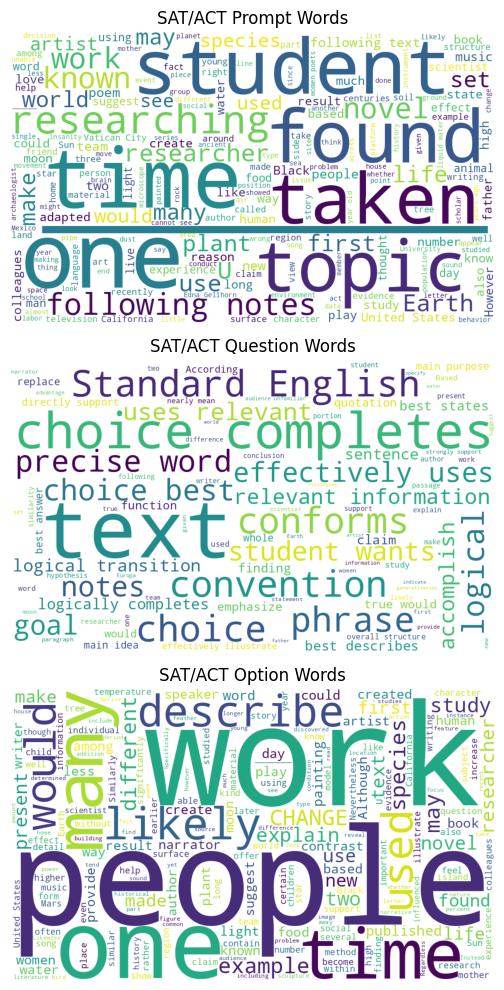

In [ ]:
plt.subplots(3, 1, figsize=(15, 10), facecolor=None)

plt.subplot(3,1, 1)
plt.title('SAT/ACT Prompt Words')
plt.imshow(wc_prompt)
plt.axis("off")

plt.subplot(3,1, 2)
plt.title('SAT/ACT Question Words')
plt.imshow(wc_question)
plt.axis("off")

plt.subplot(3,1, 3)
plt.title('SAT/ACT Option Words')
plt.imshow(wc_options)
plt.axis("off")

plt.tight_layout()
plt.show()

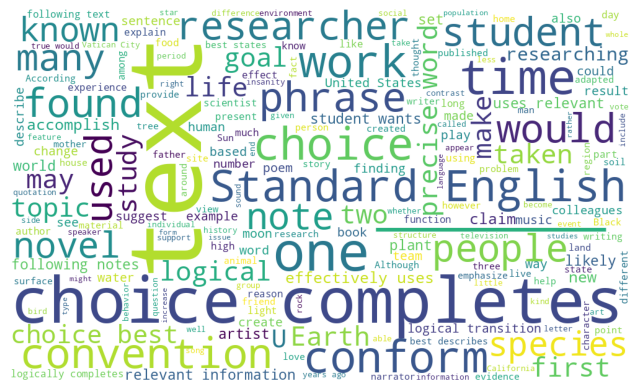

In [26]:
def concat_corpus(row):
  answer_choices = f"{row['mc_a']} {row['mc_b']} {row['mc_c']} {row['mc_d']}"
  return f"{row['prompt']} {row['question']} {answer_choices}"

wc_sat = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(sat_df.apply(concat_corpus, axis=1).str.cat(sep=' '))

plt.figure(figsize=(8,5), facecolor=None)
#plt.title('SAT/ACT Common Words', fontsize=24)
plt.imshow(wc_sat)
plt.axis("off")
plt.show()

In [ ]:
# reading score
print(f"Prompt FRE = {Readability(sat_df.prompt.str.cat(sep=' ')).flesch().score}")
print(f"Prompt Dale Chall = {Readability(sat_df.prompt.str.cat(sep=' ')).dale_chall().score}\n")

print(f"Question FRE = {Readability(sat_df.question.str.cat(sep=' ')).flesch().score}")
print(f"Question Dale Chall = {Readability(sat_df.question.str.cat(sep=' ')).dale_chall().score}\n")

print(f"Option FRE = {Readability(sat_df[['mc_a', 'mc_b', 'mc_c', 'mc_d']].apply(tuple, axis=1).str.join(' ').str.cat(sep=' ')).flesch().score}")
print(f"Option Dale Chall = {Readability(sat_df[['mc_a', 'mc_b', 'mc_c', 'mc_d']].apply(tuple, axis=1).str.join(' ').str.cat(sep=' ')).dale_chall().score}\n")

Prompt FRE = 46.18313825111622
Prompt Dale Chall = 10.027004644116886

Question FRE = 66.73978710656856
Question Dale Chall = 10.30509842472945

Option FRE = 39.07348779115654
Option Dale Chall = 10.581515680921386



# RACE-H

Download here: https://www.cs.cmu.edu/~glai1/data/race/

**Note:** I haven't been able to get the official copy, unofficial copy here: https://huggingface.co/datasets/ehovy/race

In [14]:
fp = "/content/drive/MyDrive/Master's/Second Year Grad/NLU/NLU_FinalProject/Data/"

race_df = pd.concat([pd.read_csv(fp + 'RACE-H_train.csv'),
                    pd.read_csv(fp + 'RACE-H_test.csv'),
                    pd.read_csv(fp + 'RACE-H_dev.csv')])

print(len(race_df))
race_df.head()

69394


id                                             prompt  \
0  high7294.txt  You may have heard the term "the American Drea...   
1  high7294.txt  You may have heard the term "the American Drea...   
2  high7294.txt  You may have heard the term "the American Drea...   
3  high4845.txt  How to Tell If Someone Is Happy or Sad on the ...   
4  high4845.txt  How to Tell If Someone Is Happy or Sad on the ...   

                                            question answer  \
0                     It can be inferred that   _  .      C   
1  Why did most of the early immigrants work as r...      B   
2              What's the best title of the passage?      D   
3            How many emotions can the sensors tell?      D   
4  Why do most people feel less intense in the mo...      B   

                                                mc_a  \
0     America's golden dream could never be realized   
1  Because they could earn more money as railroad...   
2                      Wave of Immigrants to America   
3                                                Two   
4         Because morning is the start of a new day.   

                                                mc_b  \
0  America's golden dream had bought great fortun...   
1  Because they had to make a living by working a...   
2                               Make Fortunes Abroad   
3                                              Three   
4        because they feel too tired in the morning.   

                                                mc_c  \
0  each period of time has its own taste of the A...   
1  Because they thought railroad was the first st...   
2                         Hard Work Leads to Success   
3                                               Four   
4        Because of humans' physiological structure.   

                                                mc_d  
0  determination and hard work are the best way t...  
1  Because railroad laborers were greatly honored...  
2                  Changes of America's Golden Dream  
3                                               Five  
4      Because of the fresh air and bright sunlight.

In [15]:
race_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 69394 entries, 0 to 3450
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        69394 non-null  object
 1   prompt    69394 non-null  object
 2   question  69394 non-null  object
 3   answer    69394 non-null  object
 4   mc_a      69391 non-null  object
 5   mc_b      69394 non-null  object
 6   mc_c      69393 non-null  object
 7   mc_d      69393 non-null  object
dtypes: object(8)
memory usage: 4.8+ MB


In [ ]:
# number of unique article/question pairs
len(race_df[['id', 'prompt', 'question']].drop_duplicates())

69389

In [16]:
dup = race_df[race_df[['id', 'prompt', 'question']].duplicated(keep=False)]

print('Number of duplicated options: ', dup[['mc_a', 'mc_b', 'mc_c', 'mc_d']].duplicated().sum())
print('Duplicated options: ', dup[dup[['mc_a', 'mc_b', 'mc_c', 'mc_d']].duplicated()].iloc[0])

dup

Number of duplicated options:  1
Duplicated options:  id                                              high11497.txt
prompt      The soldiers had just moved to the desert, and...
question        What do you think of the ending of the story?
answer                                                      A
mc_a        It is quite reasonable that the officer ordere...
mc_b        We'll laugh at the officer's order because it ...
mc_c        Though the officer's order sounded wise, the s...
mc_d        The soldier managed to cover the shadow with sand
Name: 55661, dtype: object


id                                             prompt  \
10802   high7533.txt  The Erie Canal was the first important nationa...   
10803   high7533.txt  The Erie Canal was the first important nationa...   
25394   high7532.txt  Foulsham House is a fine, large house of the 1...   
25396   high7532.txt  Foulsham House is a fine, large house of the 1...   
48880   high7237.txt  We were moving to a new state after my husband...   
48882   high7237.txt  We were moving to a new state after my husband...   
54834   high2567.txt  Some people have very good memory  and they ca...   
54838   high2567.txt  Some people have very good memory  and they ca...   
55660  high11497.txt  The soldiers had just moved to the desert, and...   
55661  high11497.txt  The soldiers had just moved to the desert, and...   

                                                question answer  \
10802  Which of the following is true according to th...      A   
10803  Which of the following is true according to th...      D   
25394                                  Foulsham House  _      C   
25396                                  Foulsham House  _      A   
48880   We can learn from the text that the family  _  .      B   
48882   We can learn from the text that the family  _  .      D   
54834                    Which of the following is true?      D   
54838                    Which of the following is true?      B   
55660      What do you think of the ending of the story?      A   
55661      What do you think of the ending of the story?      A   

                                                    mc_a  \
10802  The Erie Canal brought profits of over $114, 0...   
10803   Clinton broke ground for the canal at both ends.   
25394                                is an old farmhouse   
25396          is an old house that meets many new needs   
48880                              had a hopeless future   
48882              got out of their financial difficulty   
54834  Charles Dickens had a good memory because he w...   
54838                   We all keep a diary in our mind.   
55660  It is quite reasonable that the officer ordere...   
55661  It is quite reasonable that the officer ordere...   

                                                    mc_b  \
10802  It's 363 miles from the Great Lakes to the Atl...   
10803  Clinton started building the canal before he b...   
25394       stands 25 hectares high above the River Byer   
25396     though seventy-nine years old, meets new needs   
48880                        was in financial difficulty   
48882                  met with more troubles after that   
54834  People without a good memory cannot be great m...   
54838  One has to do a lot of work before he can keep...   
55660  We'll laugh at the officer's order because it ...   
55661  We'll laugh at the officer's order because it ...   

                                                    mc_c  \
10802  The West was more advanced than the East when ...   
10803  All parts of the canal were completed at the s...   
25394  is an old, stone house, standing in very fine ...   
25396           is a new house that meets many old needs   
48880                      suffered from a company crash   
48882  came back to thank the couple who had helped them   
54834  People became great because they have a good m...   
54838  A person with a good memory can remember thing...   
55660  Though the officer's order sounded wise, the s...   
55661  Though the officer's order sounded wise, the s...   

                                                    mc_d  
10802  Many other states helped New York built the ca...  
10803        Construction of the canal took eight years.  
25394     is twenty-five years old, and is of fine stone  
25396             is a house of the 1970s as good as new  
48880         wanted to turn to their relatives for help  
48882  followed the couple's example in return for th...  
54834  Many people may never become great though they...  

In [ ]:
# example
ex = race_df.sample()
for col in ex.columns:
  print(f'\n{col}: {ex[col].iloc[0]}')


id: high8059.txt

prompt: Self-control can make you happier not only in the long-run, but also in the moment.
The research showed that self-control isn't about giving up desires, but more about managing conflicting goals. Since most people consider highly self-controlled ones as being more task-centered, the scientists decided to find out the connection between self-control and people's happiness to determine if being self-disciplined leaves people feel less joyful.
Through a set of tests-including one that assessed 414 middle-aged participants on self-control and another that randomly interviewed volunteers on their smart phones about their mood and any desires they might be experiencing, researchers found a strong connection between higher levels of self-control and satisfaction.
The smart phone experiment also showed how self-control may improve mood. Those who showed the greatest self-control reported more good moods and fewer bad ones. But this didn't appear to be linked to being

In [ ]:
# average length
print(f'Average article length: {race_df.prompt.apply(lambda x: len(word_tokenize(x))).mean()}')
print(f'Average question length: {race_df.question.apply(lambda x: len(word_tokenize(x))).mean()}')

Average article length: 355.08693835201893
Average question length: 11.403507507853705


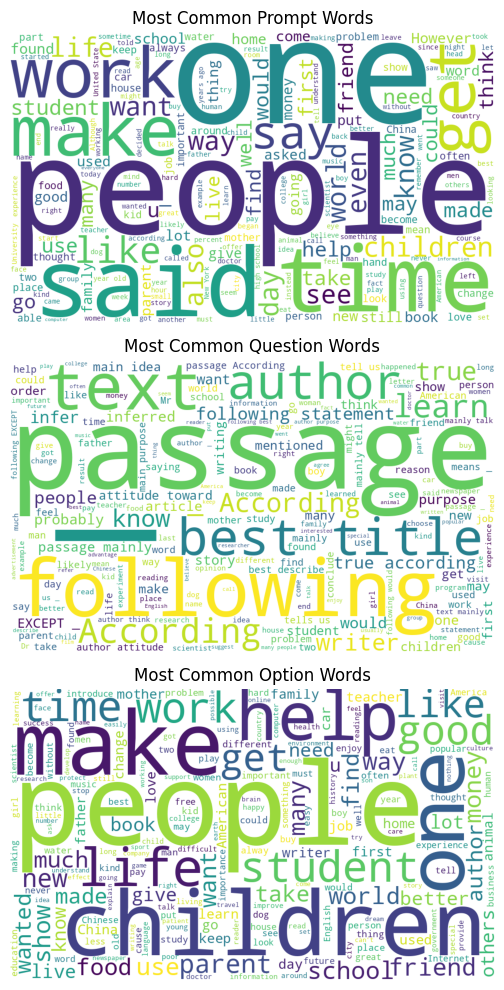

In [ ]:
# most common words

wc_prompt = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(race_df.prompt.str.cat(sep=' '))

wc_question = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(race_df.question.str.cat(sep=' '))

wc_options = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(race_df[['mc_a', 'mc_b', 'mc_c', 'mc_d']].apply(tuple, axis=1).str.join(' ').str.cat(sep=' '))

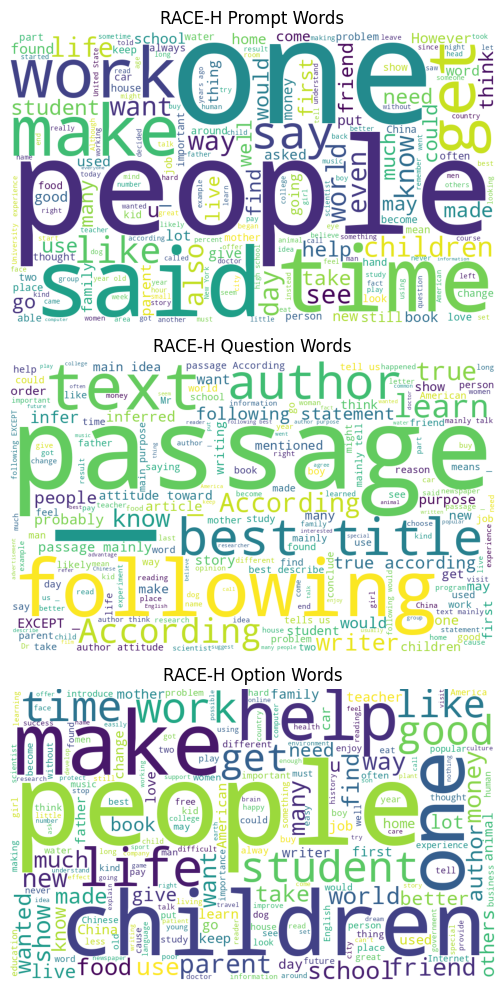

In [ ]:
plt.subplots(3, 1, figsize=(15, 10), facecolor=None)

plt.subplot(3,1, 1)
plt.title('RACE-H Prompt Words')
plt.imshow(wc_prompt)
plt.axis("off")

plt.subplot(3,1, 2)
plt.title('RACE-H Question Words')
plt.imshow(wc_question)
plt.axis("off")

plt.subplot(3,1, 3)
plt.title('RACE-H Option Words')
plt.imshow(wc_options)
plt.axis("off")

plt.tight_layout()
plt.show()

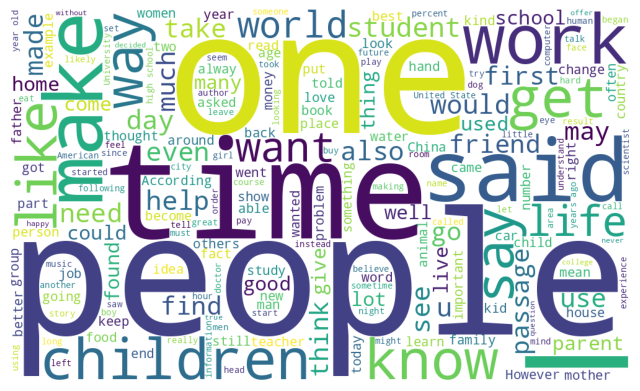

In [28]:
def concat_corpus(row):
  answer_choices = f"{row['mc_a']} {row['mc_b']} {row['mc_c']} {row['mc_d']}"
  return f"{row['prompt']} {row['question']} {answer_choices}"

wc_race = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(race_df.apply(concat_corpus, axis=1).str.cat(sep=' '))

plt.figure(figsize=(8,5), facecolor=None)
#plt.title('RACE-H Common Words', fontsize=24)
plt.imshow(wc_race)
plt.axis("off")
plt.show()

In [ ]:
# reading score
print(f"Prompt FRE = {Readability(race_df.prompt.str.cat(sep=' ')).flesch().score}")
print(f"Prompt Dale Chall = {Readability(race_df.prompt.str.cat(sep=' ')).dale_chall().score}\n")

print(f"Question FRE = {Readability(race_df.question.str.cat(sep=' ')).flesch().score}")
print(f"Question Dale Chall = {Readability(race_df.question.str.cat(sep=' ')).dale_chall().score}\n")

print(f"Option FRE = {Readability(race_df[['mc_a', 'mc_b', 'mc_c', 'mc_d']].apply(tuple, axis=1).str.join(' ').str.cat(sep=' ')).flesch().score}")
print(f"Option Dale Chall = {Readability(race_df[['mc_a', 'mc_b', 'mc_c', 'mc_d']].apply(tuple, axis=1).str.join(' ').str.cat(sep=' ')).dale_chall().score}\n")

Prompt FRE = 64.51565663475175
Prompt Dale Chall = 7.95708190354838

Question FRE = 75.85119644245572
Question Dale Chall = 8.19250877518206

Option FRE = 61.57821201093995
Option Dale Chall = 7.736201532021221



# MultiRC

Download here: https://cogcomp.seas.upenn.edu/multirc/

In [ ]:
import json

# training set
fp = 'train_456-fixedIds.json'
with open(fp, 'r') as f:
  multirc = json.load(f)

multirc.keys()

dict_keys(['data'])

In [ ]:
print(f"Number of training texts = {len(multirc['data'])}")

num_q = 0
for p in multirc['data']:
  num_q += len(p['paragraph']['questions'])

print(f"Number of total questions = {num_q}")

Number of training texts = 456
Number of total questions = 5131


In [ ]:
multirc['data'][0].keys()

dict_keys(['paragraph', 'id'])

In [ ]:
multirc['data'][0]['paragraph'].keys()

dict_keys(['text', 'questions'])

In [ ]:
multirc['data'][0]['paragraph']['text']

'<b>Sent 1: </b>Animated history of the US.<br><b>Sent 2: </b>Of course the cartoon is highly oversimplified, and most critics consider it one of the weakest parts of the film.<br><b>Sent 3: </b>But it makes a valid claim which you ignore entirely: That the strategy to promote "gun rights" for white people and to outlaw gun possession by black people was a way to uphold racism without letting an openly terrorist organization like the KKK flourish.<br><b>Sent 4: </b>Did the 19th century NRA in the southern states promote gun rights for black people?<br><b>Sent 5: </b>I highly doubt it.<br><b>Sent 6: </b>But if they didn\'t, one of their functions was to continue the racism of the KKK.<br><b>Sent 7: </b>This is the key message of this part of the animation, which is again being ignored by its critics.<br><b>Sent 8: </b>Buell shooting in Flint.<br><b>Sent 9: </b>You write: "Fact: The little boy was the class thug, already suspended from school for stabbing another kid with a pencil, and h

In [ ]:
print(f"Number of questions for this text: {len(multirc['data'][0]['paragraph']['questions'])}\n")
random.choice(multirc['data'][0]['paragraph']['questions'])

Number of questions for this text: 12



{'question': 'It is believed that which group tolerated crack sales raising what other questions>',
 'sentences_used': [12, 13, 14],
 'answers': [{'text': 'CIA tolerated crack sales, which raises questions about how the epidemic spread in the U.S',
   'isAnswer': True,
   'scores': {}},
  {'text': 'The FBI tolerated crack sales because it is a lucrative business',
   'isAnswer': False,
   'scores': {}},
  {'text': 'The Buell shooting in Flint raised suggests the federal government should treat minors like adults',
   'isAnswer': False,
   'scores': {}},
  {'text': 'It is believed the CIA tolerated crack sales, raising other questions "Why do people deal drugs" and "do they do it because it is fun"?',
   'isAnswer': True,
   'scores': {}},
  {'text': 'CIA tolerated crack sales in US cities to fund the operation of South American "contras"',
   'isAnswer': True,
   'scores': {}},
  {'text': 'Black people tolerated crack dealing, which raises questions about their patriotism',
   'isAnswe

In [ ]:
# average length
texts = [x['paragraph']['text'] for x in multirc['data']]
text_tok = [len(word_tokenize(x)) for x in texts]

questions = []
answers = []
for x in multirc['data']:
  for q in x['paragraph']['questions']:
    questions.append(q['question'])
    for a in q['answers']:
      answers.append(a['text'] + '.')

quest_tok = [len(word_tokenize(x)) for x in questions]

print(f'Average text length: {sum(text_tok)/len(text_tok)}')
print(f'Average question length: {sum(quest_tok)/len(quest_tok)}')

Average text length: 459.07456140350877
Average question length: 12.486844669655039


In [ ]:
import re
text = ' '.join(texts)
text = text.replace('<br>', ' ')
text = re.sub(r"<b>Sent \d+: </b>", "", text)

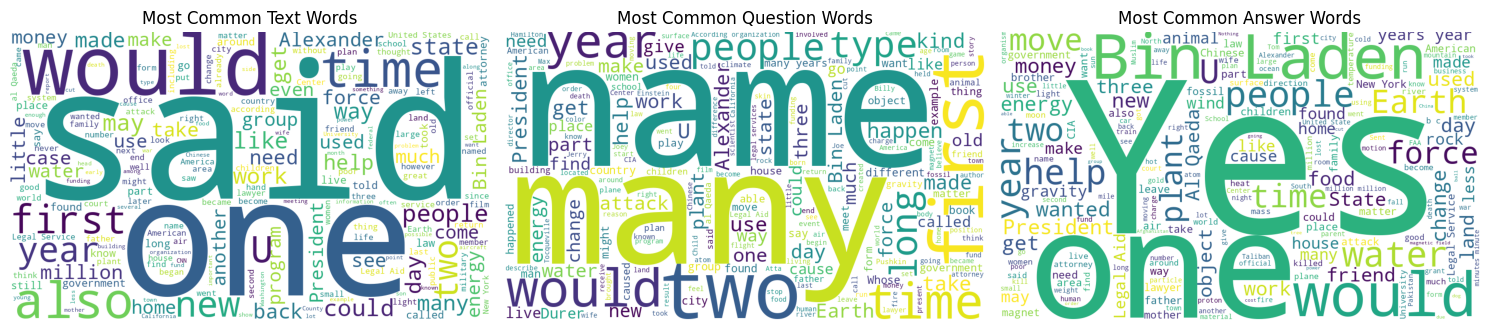

In [ ]:
# most common words

wc_prompt = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(text)

wc_question = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(' '.join(questions))

wc_options = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(' '.join(answers))

plt.subplots(1, 3, figsize=(15, 30), facecolor=None)

plt.subplot(1,3,1)
plt.title('Most Common Text Words')
plt.imshow(wc_prompt)
plt.axis("off")

plt.subplot(1,3,2)
plt.title('Most Common Question Words')
plt.imshow(wc_question)
plt.axis("off")

plt.subplot(1,3,3)
plt.title('Most Common Answer Words')
plt.imshow(wc_options)
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# reading score
print(f"Prompt FRE = {Readability(text).flesch().score}")
print(f"Prompt Dale Chall = {Readability(text).dale_chall().score}\n")

print(f"Question FRE = {Readability(' '.join(questions)).flesch().score}")
print(f"Question Dale Chall = {Readability(' '.join(questions)).dale_chall().score}\n")

print(f"Option FRE = {Readability(' '.join(answers)).flesch().score}")
print(f"Option Dale Chall = {Readability(' '.join(answers)).dale_chall().score}\n")

Prompt FRE = 55.47444822520191
Prompt Dale Chall = 9.167161593011153

Question FRE = 70.85452284459532
Question Dale Chall = 9.214792474645504

Option FRE = 67.63566210185004
Option Dale Chall = 9.124969852105108



# MCTest

Download here: https://mattr1.github.io/mctest/data.html

In [ ]:
# training set
mctest_df = pd.read_csv('mc500.train.tsv', sep='\t', header=None)
mctest_df.shape

(300, 23)

In [ ]:
mctest_df.rename(columns={0:'ID', 1:'info', 2:'text'}, inplace=True)
mctest_df.head()

ID                                               info  \
0  mc500.train.0  Author: 2778399758;Work Time(s): 839;Qual. sco...   
1  mc500.train.1  Author: 3208685851;Work Time(s): 836;Qual. sco...   
2  mc500.train.2  Author: 3165469218;Work Time(s): 1546;Qual. sc...   
3  mc500.train.3  Author: 3323630398;Work Time(s): 712;Qual. sco...   
4  mc500.train.4  Author: 646501657;Work Time(s): 743;Qual. scor...   

                                                text  \
0  Alyssa got to the beach after a long trip. She...   
1  One morning, Elena woke up, much like she did ...   
2  Billy was like a king on the school yard. A ki...   
3  Billy went to the farm to buy some beef for hi...   
4  The road to Grandpa's house was long and windi...   

                                                   3  \
0                       one: What city is Alyssa in?   
1  multiple: What is the very first thing Elena d...   
2                      multiple: Billy was like a...   
3               one: What did Billy buy at the farm?   
4         multiple: Why did Grandpa answer the door?   

                            4                                   5  \
0                        trip                               Miami   
1  she says hello to the tree  she throws the covers on the floor   
2                      prince                               dummy   
3                        Beef                             Chicken   
4  Because he saw the insects           Because Jimmy was walking   

                           6                                  7  \
0                    Atlanta                              beach   
1  she says hello to the sun                she gets out of bed   
2                      queen                               king   
3                       Cows                              Fence   
4      Because Jimmy knocked  Because the trip took a long time   

                                                   8                9  ...  \
0                   one: Why did Alyssa go to Miami?             swim  ...   
1  one: At what time of day does this story take ...  Before the tree  ...   
2                           multiple: Who was Billy?   The skinny kid  ...   
3   multiple: What color were the spots on the cows?             Blue  ...   
4           one: Where do Jimmy and his Grandpa sit?       On insects  ...   

                                                  13  \
0       multiple: How many friends does Alyssa have?   
1    multiple: What happened to Mr. Fish in the end?   
2          one: What did the boy grab from his home?   
3  multiple: How many chickens were on the purple...   
4  multiple: What was Jimmy's favorite insect in ...   

                                             14  \
0                                             1   
1  He got put back in the bowl, but he was dead   
2                                        a rock   
3                                           Ten   
4                                        Beetle   

                                           15                        16  \
0                                           2                         3   
1  He started swimming around in Elena's hand  He got put in a new bowl   
2                                     a bench                    a tree   
3                                         Six                      Five   
4                                    Lady bug                      Moth   

                                                  17  \
0                                                  4   
1  He got put back in his bowl and started swimmi...   
2                                       Fishing line   
3                                               Four   
4                                      Lightning bug   

                                                 18  \
0  multiple: What did Alyssa eat at the restaurant?   
1    multiple: What was missing from the fish bowl?   
2                 one: What d

In [ ]:
print(f'Number of unique texts = {mctest_df.text.nunique()}')

Number of unique texts = 300


In [ ]:
# getting answers
with open('mc500.train.ans', 'r') as f:
  answers = f.readlines()

random.choice(answers)

'C\tD\tD\tB\n'

In [ ]:
# example
ex = mctest_df.sample().iloc[0]
print(f"Info: {ex['info']}\n")
print(f"Text: {ex['text']}\n")
print(f"Question: {ex[3]}\n")
print(f"Options:\n{ex[[4, 5, 6, 7]]}\n")
print(f"Question: {ex[8]}\n")
print(f"Options:\n{ex[[9, 10, 11, 12]]}\n")

Info: Author: 2778399758;Work Time(s): 928;Qual. score: 80;Creativity Words: have,why,spaghetti,not,jump,bow,bleed,mean,sour,name,farm,kitten,bird,box,like

Text: Tony was at home and making dinner. He wanted spaghetti so he made that and some bread too. He added some spices and sauce too. After making dinner, he fed his kitten. His kitten's name is Marbles. Tony was going to name him Arlo or Jack but chose Marbles. Tony played with Marbles for hours. He also cleaned the room and kitchen. After playing with Marbles, Tony went to sleep. The next day, Tony woke up to a bird calling out his window. He got out of bed and got ready for the day. He made some eggs and toast. After eating, he headed to the park. The park was pretty empty. Tony walked around the park. Tony talked to some people after walking. He watched some kids playing and having a good time. It made him feel good. After a few hours, Tony left the park to go home. He laid in his bed and watched TV. It was nice for Tony to hav

In [ ]:
mctest_df['questions'] = mctest_df[[3, 8, 13, 18]].apply(tuple, axis=1).str.join(' ')
mctest_df['answers'] = mctest_df[[4, 5, 6, 7,
                                  9, 10, 11, 12,
                                  14, 15, 16, 17,
                                  19, 20, 21, 22]].apply(tuple, axis=1).str.join('. ')

In [ ]:
# average length
print(f'Average text length: {mctest_df.text.apply(lambda x: len(word_tokenize(x))).mean()}')
print(f'Average question length: {mctest_df.questions.apply(lambda x: len(word_tokenize(x))).mean()/4}')

Average text length: 247.1
Average question length: 10.959166666666667


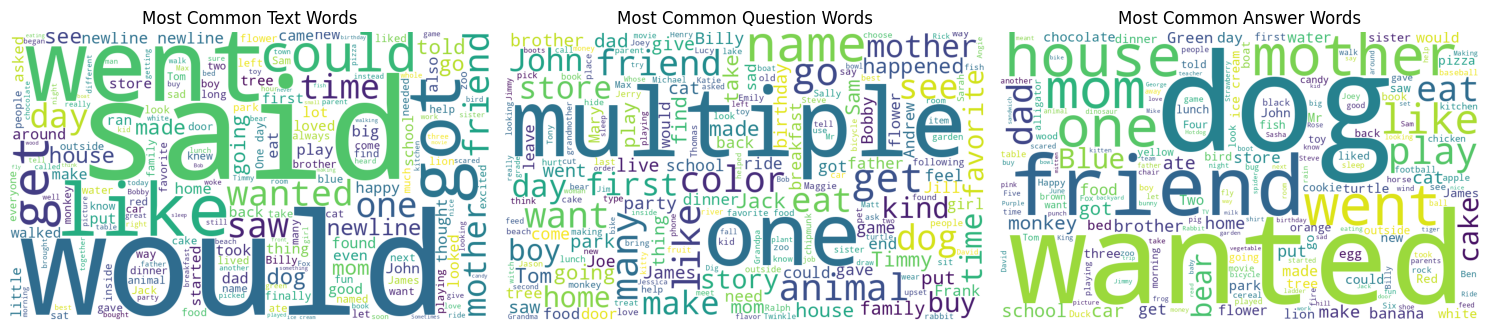

In [ ]:
# most common words

wc_prompt = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(mctest_df.text.str.cat(sep=' '))

wc_question = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(mctest_df.questions.str.cat(sep=' '))

wc_options = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    stopwords=stopwords.words('english'),
    min_font_size=10
).generate(mctest_df.answers.str.cat(sep=' '))

plt.subplots(1, 3, figsize=(15, 30), facecolor=None)

plt.subplot(1,3,1)
plt.title('Most Common Text Words')
plt.imshow(wc_prompt)
plt.axis("off")

plt.subplot(1,3,2)
plt.title('Most Common Question Words')
plt.imshow(wc_question)
plt.axis("off")

plt.subplot(1,3,3)
plt.title('Most Common Answer Words')
plt.imshow(wc_options)
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# reading score
print(f"Prompt FRE = {Readability(mctest_df.text.str.cat(sep=' ')).flesch().score}")
print(f"Prompt Dale Chall = {Readability(mctest_df.text.str.cat(sep=' ')).dale_chall().score}\n")

print(f"Question FRE = {Readability(mctest_df.questions.str.cat(sep=' ')).flesch().score}")
print(f"Question Dale Chall = {Readability(mctest_df.questions.str.cat(sep=' ')).dale_chall().score}\n")

print(f"Option FRE = {Readability(mctest_df.answers.str.cat(sep=' ')).flesch().score}")
print(f"Option Dale Chall = {Readability(mctest_df.answers.str.cat(sep=' ')).dale_chall().score}\n")

Prompt FRE = 85.07465316281247
Prompt Dale Chall = 6.207407854811379

Question FRE = 86.5540735631871
Question Dale Chall = 8.096330945319608

Option FRE = 92.38490860281877
Option Dale Chall = 6.7781024252586

